## CESM2 - LARGE ENSEMBLE (LENS2)

#### by Mauricio Rocha and Dr. Gustavo Marques

 - This Notebook aims to find the maximum, minimum, mean and root mean square error of the AMOC in the South Atlantic for the historical period.

## Imports

In [1]:
import xarray as xr
import pandas as pd
import numpy as np 
import dask
import cf_xarray
import intake
import cftime
import nc_time_axis
import intake_esm
import matplotlib.pyplot as plt
import pop_tools
from dask.distributed import Client
from ncar_jobqueue import NCARCluster
import warnings, getpass, os

### Local functions

In [2]:
def rms_da(da, dims=('moc_z','lat_aux_grid'), weights=None,  weights_sum=None):
  """
  Calculates the rms in DataArray da (optional weighted rms).

  ----------
  da : xarray.DataArray
        DataArray for which to compute (weighted) rms.

  dims : tuple, str
    Dimension(s) over which to apply reduction. Default is ('yh', 'xh').

  weights : xarray.DataArray, optional
    weights to apply. It can be a masked array.

  weights_sum : xarray.DataArray, optional
    Total weight (i.e., weights.sum()). Only computed if not provided.

  Returns
  -------
  reduction : DataSet
      xarray.Dataset with (optionally weighted) rms for da.
  """

  if weights is not None:
    if weights_sum is None: weights_sum = weights.sum(dim=dims)
    out = np.sqrt((da**2 * weights).sum(dim=dims)/weights_sum)
    # copy attrs
    out.attrs = da.attrs
    return out
  else:
    return np.sqrt((da**2).mean(dim=dims, keep_attrs=True))

## Improve the workflow using clusters 

In [3]:
mem_per_worker = 40 # in GB 
num_workers = 60 
cluster = NCARCluster(cores=1, processes=3, memory=f'{mem_per_worker} GB',resource_spec=f'select=1:ncpus=6:mem={mem_per_worker}GB')
cluster.scale(num_workers)
client = Client(cluster)
print(client)
client

<Client: 'tcp://10.12.206.39:45727' processes=0 threads=0, memory=0 B>


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.39:45727,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Read in OGCM history file & MOC template file

In [4]:
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

/glade/u/home/mauricio/.local/lib/python3.8/site-packages/intake_esm/utils.py:96: DtypeWarning: Columns (5,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(catalog_path, **csv_kwargs), catalog_path


In [5]:
cat_subset = catalog.search(component='ocn',variable=['MOC'],frequency='month_1',experiment="historical")
del catalog

In [6]:
# Load catalog entries for subset into a dictionary of xarray datasets
dset_dict_raw  = cat_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})
print(f"\nDataset dictionary keys:\n {dset_dict_raw.keys()}")
del cat_subset


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'



Dataset dictionary keys:
 dict_keys(['ocn.historical.pop.h.cmip6.MOC', 'ocn.historical.pop.h.smbb.MOC'])


In [7]:
%%time
fb=('cmip6','smbb')
for ifb in range(0,2):  
    print(f"Forcing_variant: {ifb}")
    str=f'ds_{fb[ifb]}_moc = dset_dict_raw[\'ocn.historical.pop.h.{fb[ifb]}.MOC\']' 
    exec(str)
    str=f'ds_{fb[ifb]}_moc = ds_{fb[ifb]}_moc.sel(time=slice(\'1850-01-01\', \'2014-12-31\')).resample(time=\'1Y\', closed=\'left\').mean(\'time\')' # Time Series and annual mean
    exec(str)
    str=f'moc_{fb[ifb]} = ds_{fb[ifb]}_moc[\'MOC\']' # Variable
    exec(str)
    str=f'del ds_{fb[ifb]}_moc'
    exec(str)

Forcing_variant: 0
Forcing_variant: 1
CPU times: user 9.65 s, sys: 49.3 ms, total: 9.7 s
Wall time: 9.97 s


In [8]:
%%time
for ifb in range(0,2): 
    print(f"Forcing_variant: {ifb}")
    str=f'moc_{fb[ifb]}[\'moc_z\'] = -0.01*moc_{fb[ifb]}.moc_z' # cm to m and negative depth
    print(str)
    exec(str) 

Forcing_variant: 0
moc_cmip6['moc_z'] = -0.01*moc_cmip6.moc_z
Forcing_variant: 1
moc_smbb['moc_z'] = -0.01*moc_smbb.moc_z
CPU times: user 2.08 ms, sys: 0 ns, total: 2.08 ms
Wall time: 2.09 ms


In [9]:
area_sa=moc_smbb.coords['lat_aux_grid'].sel(lat_aux_grid=slice(-25.91623,-1.413613))

In [10]:
moc=xr.combine_nested([moc_cmip6,moc_smbb],concat_dim=['member_id'])
MOC_max = np.empty((len(moc['time']),len(moc['member_id']))) * np.nan
MOC_mean = np.empty((len(moc['time']),len(moc['member_id']))) * np.nan
MOC_min = np.empty((len(moc['time']),len(moc['member_id']))) * np.nan
MOC_rms = np.empty((len(moc['time']),len(moc['member_id']))) * np.nan

In [11]:
%%time
ilas=-25.91623 # southern boundary
ilan=-1.413613 # northern boundary
mx_depth=-3500 # depth limit

for it in range(0,len(moc_smbb['time'])): # time 
    print(f'Time: {it}')        
    # Maximum AMOC for the South Atlantic (see the limits)
    amoc = moc.isel(time=it,transport_reg=1).where(
    (moc.isel(time=it,transport_reg=1,moc_comp=0)['moc_z'] > mx_depth) & # depth
    (moc.isel(time=it,transport_reg=1,moc_comp=0)['lat_aux_grid'] > ilas) & # south
    (moc.isel(time=it,transport_reg=1,moc_comp=0)['lat_aux_grid'] < ilan), # north
    drop=True
    ).sum(dim='moc_comp')
    MOC_max[it,:]=amoc.max(dim=['moc_z','lat_aux_grid']).load() 
        
    # Minimum AMOC for the South Atlantic (see the limits)
    amoc = moc.isel(time=it,transport_reg=1).where(
    (moc.isel(time=it,transport_reg=1,moc_comp=0)['moc_z'] > mx_depth) & # depth
    (moc.isel(time=it,transport_reg=1,moc_comp=0)['lat_aux_grid'] > ilas) & # south
    (moc.isel(time=it,transport_reg=1,moc_comp=0)['lat_aux_grid'] < ilan), # north
    drop=True
    ).sum(dim='moc_comp')
    MOC_min[it,:]=amoc.min(dim=['moc_z','lat_aux_grid']).load() 
        
    # Mean AMOC for the South Atlant (see the limits)
    amoc = moc.isel(time=it,transport_reg=1).where(
    (moc.isel(time=it,transport_reg=1,moc_comp=0)['moc_z'] > mx_depth) & # depth
    (moc.isel(time=it,transport_reg=1,moc_comp=0)['lat_aux_grid'] > ilas) & # south
    (moc.isel(time=it,transport_reg=1,moc_comp=0)['lat_aux_grid'] < ilan), # north
    drop=True
    ).sum(dim='moc_comp')
    MOC_mean[it,:]=amoc.weighted(area_sa).mean(dim=['moc_z','lat_aux_grid']).load() 
        
    # Error AMOC for the South Atlantic (see the limits)
    amoc = moc.isel(time=it,transport_reg=1).where(
    (moc.isel(time=it,transport_reg=1,moc_comp=0)['moc_z'] > mx_depth) & # depth
    (moc.isel(time=it,transport_reg=1,moc_comp=0)['lat_aux_grid'] > ilas) & # south
    (moc.isel(time=it,transport_reg=1,moc_comp=0)['lat_aux_grid'] < ilan), # north
    drop=True
    ).sum(dim='moc_comp')
    #MOC_rms[it,:]=np.sqrt((amoc**2).mean(dim=['moc_z','lat_aux_grid'])).load() 
    MOC_rms[it,:]=rms_da(amoc, weights=area_sa, weights_sum=area_sa.sum())
    del amoc

Time: 0
Time: 1
Time: 2
Time: 3
Time: 4
Time: 5
Time: 6
Time: 7
Time: 8
Time: 9
Time: 10
Time: 11
Time: 12
Time: 13
Time: 14
Time: 15
Time: 16
Time: 17
Time: 18
Time: 19
Time: 20
Time: 21
Time: 22
Time: 23
Time: 24
Time: 25
Time: 26
Time: 27
Time: 28
Time: 29
Time: 30
Time: 31
Time: 32
Time: 33
Time: 34
Time: 35
Time: 36
Time: 37
Time: 38
Time: 39
Time: 40
Time: 41
Time: 42
Time: 43
Time: 44
Time: 45
Time: 46
Time: 47
Time: 48
Time: 49
Time: 50
Time: 51
Time: 52
Time: 53
Time: 54
Time: 55
Time: 56
Time: 57
Time: 58
Time: 59
Time: 60
Time: 61
Time: 62
Time: 63
Time: 64
Time: 65
Time: 66
Time: 67
Time: 68
Time: 69
Time: 70
Time: 71
Time: 72
Time: 73
Time: 74
Time: 75
Time: 76
Time: 77
Time: 78
Time: 79
Time: 80
Time: 81
Time: 82
Time: 83
Time: 84
Time: 85
Time: 86
Time: 87
Time: 88
Time: 89
Time: 90
Time: 91
Time: 92
Time: 93
Time: 94
Time: 95
Time: 96
Time: 97
Time: 98
Time: 99
Time: 100
Time: 101
Time: 102
Time: 103
Time: 104
Time: 105
Time: 106
Time: 107
Time: 108
Time: 109
Time: 110


In [12]:
da1 = xr.Dataset({'MOC_rms': (('time','member_id'), MOC_rms)}, coords={'time': moc.coords['time'],'member_id': moc.coords['member_id']})
da2 = xr.Dataset({'MOC_mean': (('time','member_id'), MOC_mean)}, coords={'time': moc.coords['time'],'member_id': moc.coords['member_id']})
da3 = xr.Dataset({'MOC_max': (('time','member_id'), MOC_max)}, coords={'time': moc.coords['time'],'member_id': moc.coords['member_id']})
da4 = xr.Dataset({'MOC_min': (('time','member_id'), MOC_min)}, coords={'time': moc.coords['time'],'member_id': moc.coords['member_id']})
ds_out_MOC=xr.combine_by_coords([da1, da2, da3, da4])
ds_out_MOC.attrs['description'] = 'Meridional Overturning Circulation (MOC) statistics for the South Atlantic (47.5W-23.75E and 25.91623S-1.413613S)'
ds_out_MOC.attrs['units'] = 'Sv'
ds_out_MOC.attrs['author'] = 'Mauricio Rocha'
ds_out_MOC.attrs['email'] = 'mauricio.rocha@usp.br'

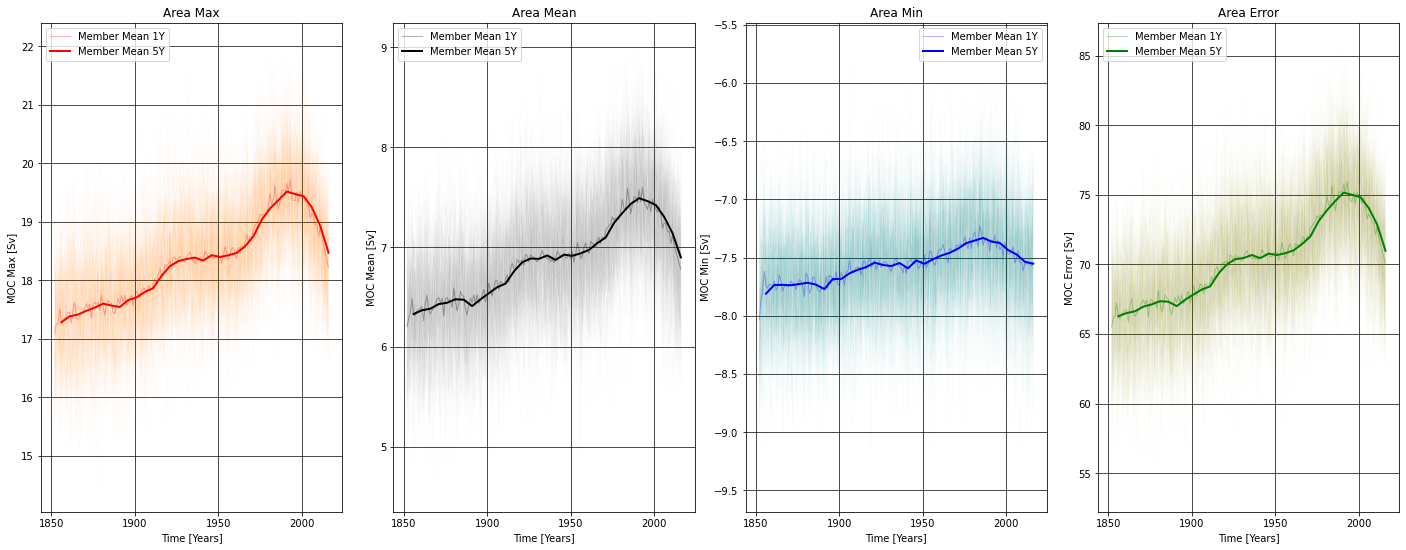

In [13]:
# Total Surface Heat Fux
fig, axes = plt.subplots(1, 4, figsize=(20, 8))
# Maximum
ds_out_MOC.MOC_max.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[0],x="time",color='orange',alpha=0.01,linewidth=1,add_legend=False)
ds_out_MOC.MOC_max.resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[0],x="time",alpha=0.3,color='r',linewidth=1,label='Member Mean 1Y')
ds_out_MOC.MOC_max.resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[0],x="time",color='r',linewidth=2,label='Member Mean 5Y')
axes[0].set_xlabel('Time [Years]')
axes[0].set_ylabel('MOC Max [Sv]')
axes[0].set_title('Area Max')
axes[0].grid(color='k', linestyle='-', linewidth=0.7)
axes[0].legend()
#axes[0].set_ylim(103,108.2)
fig.tight_layout(pad=2.0)
# Mean
ds_out_MOC.MOC_mean.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[1],x="time",color='gray',alpha=0.01,linewidth=1,add_legend=False)
ds_out_MOC.MOC_mean.resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[1],x="time",alpha=0.3,color='k',linewidth=1,label='Member Mean 1Y')
ds_out_MOC.MOC_mean.resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[1],x="time",color='k',linewidth=2,label='Member Mean 5Y')
axes[1].set_xlabel('Time [Years]')
axes[1].set_ylabel('MOC Mean [Sv]')
axes[1].set_title('Area Mean')
axes[1].grid(color='k', linestyle='-', linewidth=0.7)
axes[1].legend()
#axes[1].set_ylim(17,25.5)
# Minimum
ds_out_MOC.MOC_min.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[2],x="time",color='c',alpha=0.01,linewidth=1,add_legend=False)
ds_out_MOC.MOC_min.resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[2],x="time",alpha=0.3,color='b',linewidth=1,label='Member Mean 1Y')
ds_out_MOC.MOC_min.resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[2],x="time",color='b',linewidth=2,label='Member Mean 5Y')
axes[2].set_xlabel('Time [Years]')
axes[2].set_ylabel('MOC Min [Sv]')
axes[2].set_title('Area Min')
axes[2].grid(color='k', linestyle='-', linewidth=0.7)
axes[2].legend()
#axes[2].set_ylim(-63,-51)
# Minimum
ds_out_MOC.MOC_rms.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[3],x="time",color='y',alpha=0.01,linewidth=1,add_legend=False)
ds_out_MOC.MOC_rms.resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[3],x="time",alpha=0.3,color='g',linewidth=1,label='Member Mean 1Y')
ds_out_MOC.MOC_rms.resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[3],x="time",color='g',linewidth=2,label='Member Mean 5Y')
axes[3].set_xlabel('Time [Years]')
axes[3].set_ylabel('MOC Error [Sv]')
axes[3].set_title('Area Error')
axes[3].grid(color='k', linestyle='-', linewidth=0.7)
axes[3].legend()
#axes[3].set_ylim(50.3,52)

plt.show()

### Let's save the data in netcdf format

In [ ]:
# create a directory on scratch to save the output
path = '/glade/scratch/mauricio/LENS2_historical_south_atlantic/MOC/'.format(getpass.getuser())
os.system('mkdir -p '+path)
ds_out_MOC.to_netcdf(path+'MOC_stats.nc')